In [1]:
import pandas as pd
import missingno as msno
#nécéssite d'intaller le module : conda install -c conda-forge missingno 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_theme()
import statsmodels.api
import geopandas as gpd 

In [2]:
# Instancier notre jeu de donnée dans un dataframe "eco" et affichage des 5 premières lignes
eco = pd.read_csv("base_energie.csv")
eco.head()

,Code INSEE région,Région,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),...,TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%),Température (°C)
0,27,Bourgogne-Franche-Comté,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.700000
1,76,Occitanie,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.085714
2,24,Centre-Val de Loire,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.800000
3,28,Normandie,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.950000
4,52,Pays de la Loire,2013-01-01,00:00,2013-01-01T00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.800000


**Statistiques sur le dataset**

In [3]:
#affichage du nombre de lignes
print(eco.shape[0],' lignes dans le dataset')

1858176  lignes dans le dataset


visualisation des valeurs manquantes


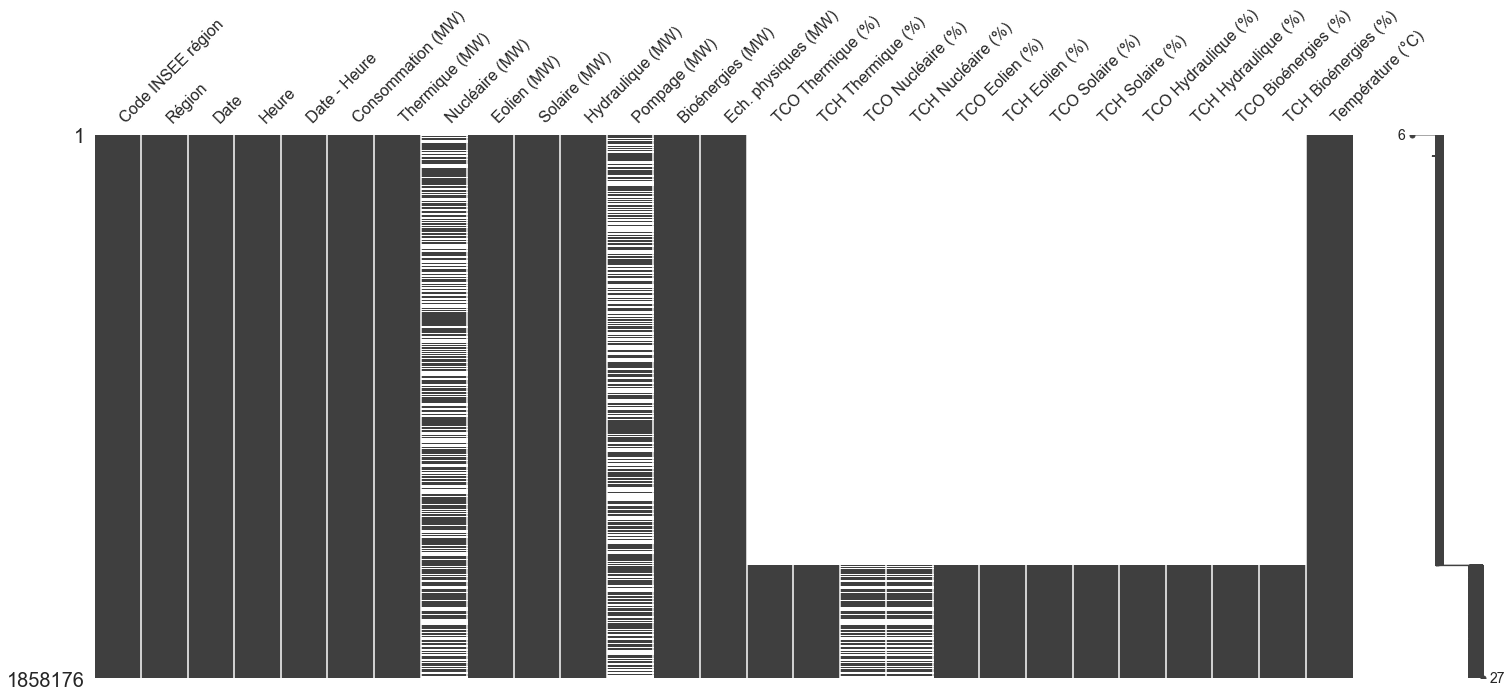

In [4]:
#Visualisation des valeurs manquantes
print('visualisation des valeurs manquantes')
msno.matrix(eco);

In [5]:
# On remplace les cellules vides par 0
eco.fillna(0, inplace=True)

visualisation des valeurs manquantes après nettoyage


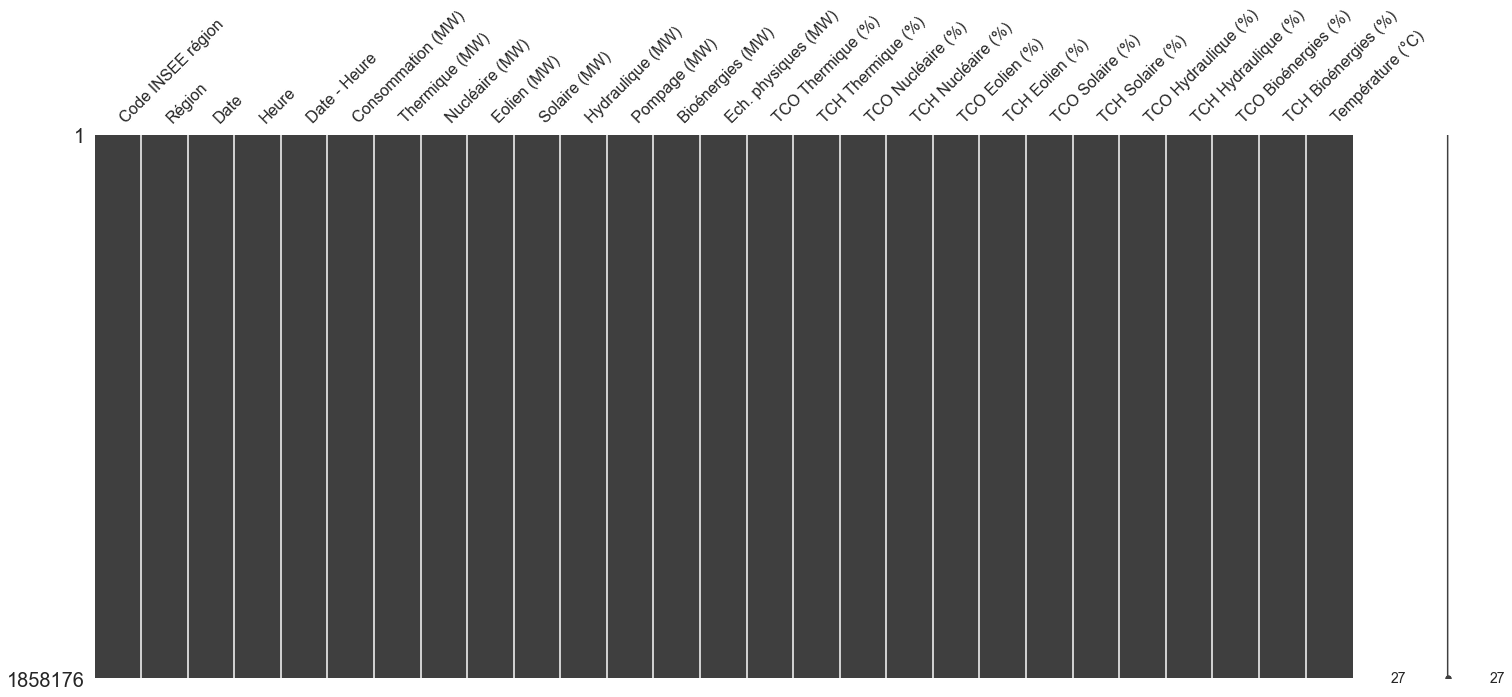

In [6]:
# Vérifier qu'aucune colonne n'a de valeur manquante
print('visualisation des valeurs manquantes après nettoyage')
msno.matrix(eco);

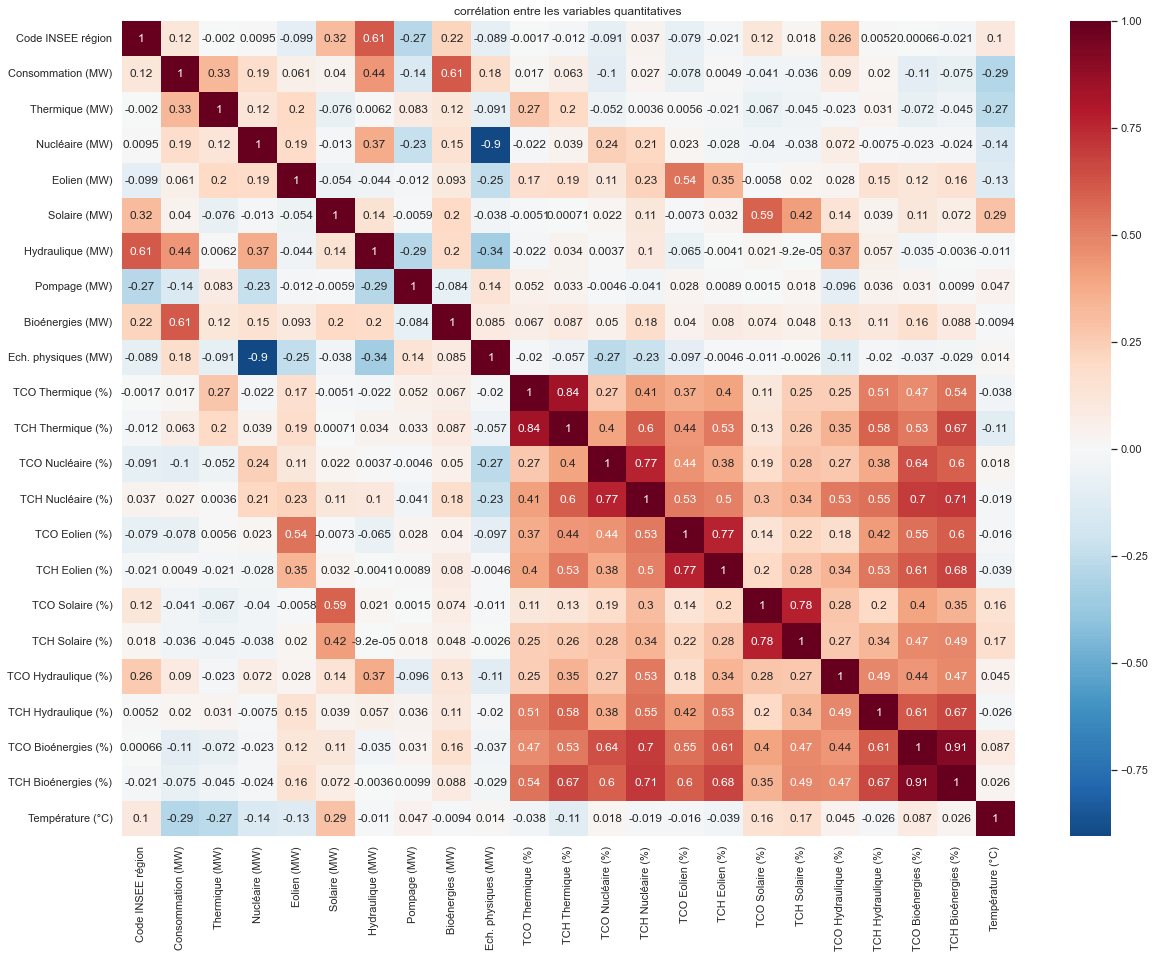

In [7]:
#Corrélation entre les variables
plt.figure(figsize=(20,15))
s1 = sns.heatmap(eco.corr(), annot=True, center=0, cmap='RdBu_r')
s1.set_title("corrélation entre les variables quantitatives"); 

Les variables les plus corrélées à la consommation : Bioénergie (0,62), Hydraulique (0,44), thermique (0,33). Le
nucléaire est relativement peu corrélé (0,18) et on constate que la variable température est négativement corrélée à la consommation (-0,29).

In [8]:
""" On crèe 3 nouvelles colonnes
Renouvelable: somme de la production d'énergie renouvalable par ligne
Production : somme de la production énergetique y compris le renouvelable par ligne
Import-Export : différence entre la production et la consommation, pour savoir si la région est déficitaire ou non"""

eco["Renouvelable"] = eco.iloc[:,8:13].sum(axis=1) + eco.iloc[:,6]
eco["Production"] = eco.iloc[:,6:13].sum(axis=1)
eco["Import-Export"] = eco["Production"] - eco["Consommation (MW)"]

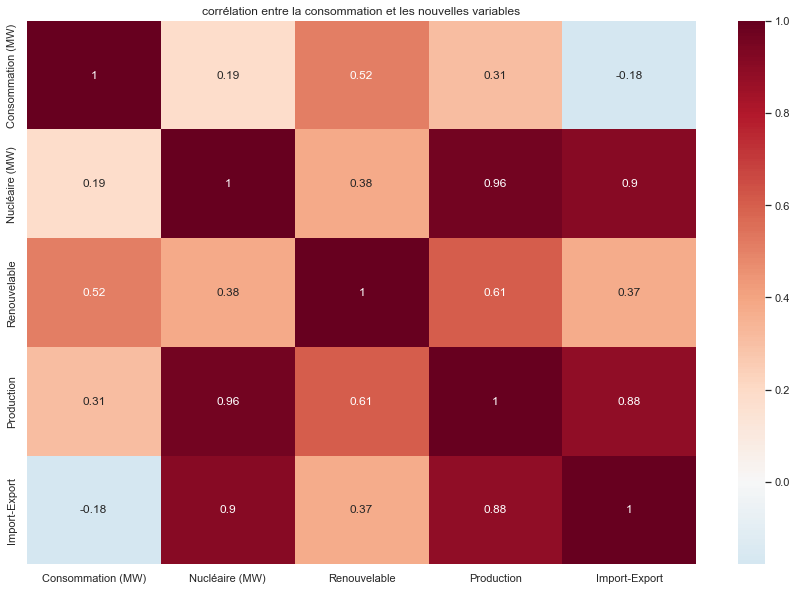

In [9]:
# Correlation entre la consommation et les nouvelles variables
plt.figure(figsize=(15,10))
s2 = sns.heatmap(eco[["Consommation (MW)","Nucléaire (MW)","Renouvelable","Production","Import-Export"]].corr(), annot=True, center=0, cmap='RdBu_r');
s2.set_title("corrélation entre la consommation et les nouvelles variables");

Les energies renouvelable et la consommation evoluent dans le même sens, on a un taux de corrélation de 0,52.
On constate que import-export et Nucléaire sont très corrélé (0,9), globalement le nuléaire à un impact sur l'importation et l'exportation au niveau national.
On pourrait en deduire qu'on exporte surtout du nucléaire et que le renouvelable est destiné à la consommation nationale.

**Données nationales**

In [10]:
# Extraction de l'annèe, du mois et du jour de la semaine
eco.Date = pd.to_datetime(eco.Date)
eco["Year"] = eco["Date"].dt.year
eco["Month"] = eco["Date"].dt.month
eco["Weekday_number"] = eco["Date"].dt.weekday
eco["Weekday_number"] = eco["Weekday_number"] + 1
eco["Day_name"] = eco["Weekday_number"].replace([1,2,3,4,5,6,7],["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"])

# Indication heure d'hiver ou d'été
eco["Gmt"] = eco["Date"].astype(str).apply(lambda x : int(x[-4]))
eco.head()

,Code INSEE région,Région,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),...,TCH Bioénergies (%),Température (°C),Renouvelable,Production,Import-Export,Year,Month,Weekday_number,Day_name,Gmt
0,27,Bourgogne-Franche-Comté,2013-01-01,00:00,2013-01-01T00:00:00+01:00,0.0,0.0,0.0,0.0,0.0,...,0.0,2.700000,0.0,0.0,0.0,2013,1,2,Mardi,1
1,76,Occitanie,2013-01-01,00:00,2013-01-01T00:00:00+01:00,0.0,0.0,0.0,0.0,0.0,...,0.0,6.085714,0.0,0.0,0.0,2013,1,2,Mardi,1
2,24,Centre-Val de Loire,2013-01-01,00:00,2013-01-01T00:00:00+01:00,0.0,0.0,0.0,0.0,0.0,...,0.0,7.800000,0.0,0.0,0.0,2013,1,2,Mardi,1
3,28,Normandie,2013-01-01,00:00,2013-01-01T00:00:00+01:00,0.0,0.0,0.0,0.0,0.0,...,0.0,8.950000,0.0,0.0,0.0,2013,1,2,Mardi,1
4,52,Pays de la Loire,2013-01-01,00:00,2013-01-01T00:00:00+01:00,0.0,0.0,0.0,0.0,0.0,...,0.0,9.800000,0.0,0.0,0.0,2013,1,2,Mardi,1


In [11]:
# Vérification des jours de la semaine disponibles dans notre dataframe eco
eco[["Weekday_number","Day_name"]].drop_duplicates()

,Weekday_number,Day_name
0,2,Mardi
576,3,Mercredi
1152,4,Jeudi
1728,5,Vendredi
2304,6,Samedi
2880,7,Dimanche
3456,1,Lundi


In [12]:
# Création de la colonne representant le trimestre correspondant 
eco["Trimestre"]= pd.cut(eco.Month, bins=[0,3,6,9,12], labels=[1,2,3,4])

In [13]:
# Pour voir la liste des régions et leur code
eco[["Code INSEE région","Région"]].drop_duplicates().sort_values(by="Code INSEE région")

,Code INSEE région,Région
9,11,Île-de-France
2,24,Centre-Val de Loire
0,27,Bourgogne-Franche-Comté
3,28,Normandie
11,32,Hauts-de-France
5,44,Grand Est
4,52,Pays de la Loire
7,53,Bretagne
6,75,Nouvelle-Aquitaine
1,76,Occitanie


In [14]:
# Données agrégées par région, somme des consommations et productions 
eco_aggr = eco.groupby(["Code INSEE région","Région"], as_index=False).sum()

# Donnée agrégées par année, somme des consommations et productions
year_aggr = eco.groupby(["Year"], as_index=False).sum()

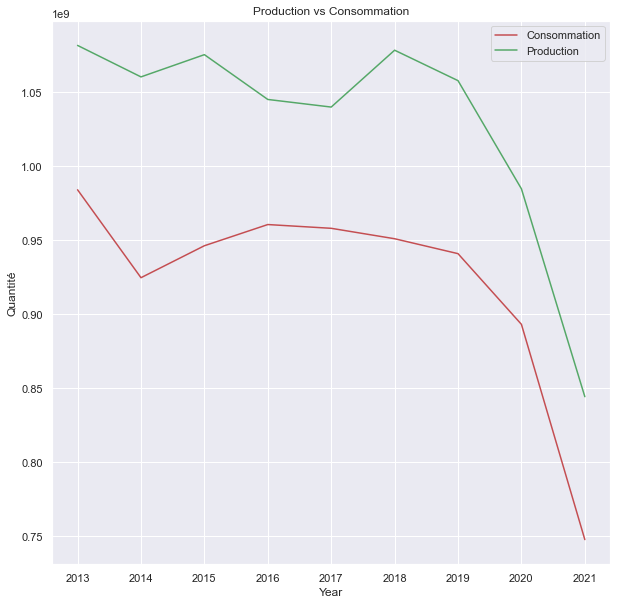

In [15]:
# Consommation et production totale, somme de toute les régions 
plt.figure(figsize=(10,10))
sns.lineplot(x="Year", y="Consommation (MW)", data=year_aggr, color = "r", label="Consommation")
sns.lineplot(x="Year", y="Production", data=year_aggr, color ="g", label="Production")
plt.title("Production vs Consommation")
plt.ylabel("Quantité")
plt.legend();

On constate que la France produit plus d'énergie qu'elle n'en consomme. La courbe de la production d'énergie au niveau national est au dessus de la courbe de consommation.
On note également que les deux courbes on globalement la même tendance.
On voit également la baisse de la production et consommation sur la période 2020-2021 certainement à cause des mesures de confinement et la Covid19.

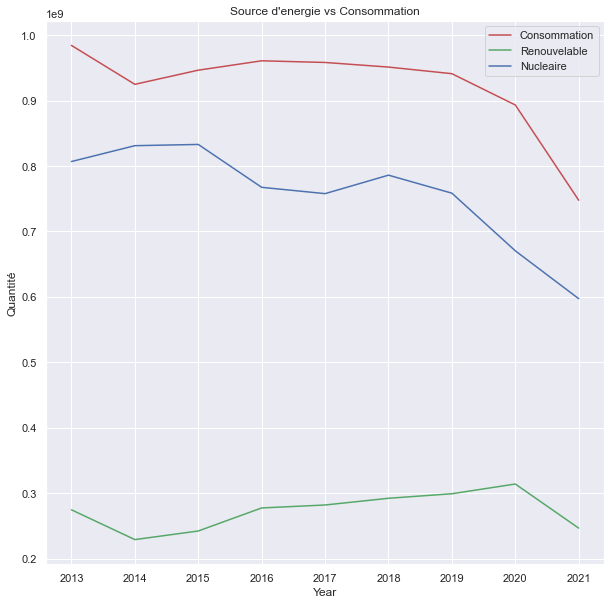

In [16]:
# Consommation et niveau de production total des énergies renouvelables, somme de toute les régions 
plt.figure(figsize=(10,10))
sns.lineplot(x="Year", y="Consommation (MW)", data=year_aggr, color = "r", label="Consommation")
sns.lineplot(x="Year", y="Renouvelable", data=year_aggr, color ="g", label="Renouvelable")
sns.lineplot(x="Year", y="Nucléaire (MW)", data=year_aggr, color ="b", label="Nucleaire")
plt.title("Source d'energie vs Consommation")
plt.ylabel("Quantité")
plt.legend();

Ce graphique nous indique qu'au niveau national la production d'énergie nucleaire occupe une place importante mais à elle seule n'est pas suffisante pour absorber la consommation nationale.
Pour cela il faut du nucléaire et du renouvelable (ce qui est visible sur le graphique "Production vs Consommation")

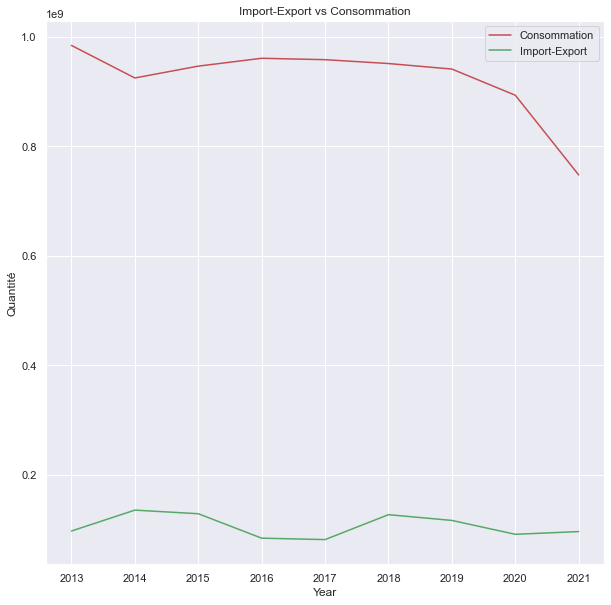

In [17]:
# Le niveau d'importation ou d'exportation d'énergie pendant toute la periode de consommation
plt.figure(figsize=(10,10))
sns.lineplot(x="Year", y="Consommation (MW)", data=year_aggr, color = "r", label="Consommation")
sns.lineplot(x="Year", y="Import-Export", data=year_aggr, color ="g", label="Import-Export")
plt.title("Import-Export vs Consommation")
plt.ylabel("Quantité")
plt.legend();

On constate que la France est un pays exportateur d'énergie mais aussi que les courbes d'Import-Export et de consommation n'évoluent pas dans le même sens.
Lorsque la consommation nationale baisse la France exporte plus d'énergie et lorsque la consommation augmente la France exporte moins d'énergie. 

In [18]:
#Calcule du rendement des différentes sources d'énergie
col = ['Thermique (MW)', 'Nucléaire (MW)','Eolien (MW)','Solaire (MW)','Hydraulique (MW)','Bioénergies (MW)','Renouvelable']
for i in col:
    year_aggr[f"Part_{i}"] = (year_aggr[i] / year_aggr["Consommation (MW)"]) * 100

year_aggr

,Year,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),...,Month,Weekday_number,Gmt,Part_Thermique (MW),Part_Nucléaire (MW),Part_Eolien (MW),Part_Solaire (MW),Part_Hydraulique (MW),Part_Bioénergies (MW),Part_Renouvelable
0,2013,10494480,984134263.0,87265040.0,806802087.0,31665608.0,9008891.0,149129252.0,-14366288.0,12227527.0,...,1372032,839808,842112,8.867188,81.980896,3.217611,0.915413,15.153344,1.242465,27.936232
1,2014,10494480,924697156.0,49924365.0,831008785.0,34116918.0,11639659.0,134720263.0,-15980203.0,15020879.0,...,1372032,840384,842112,5.398996,89.868210,3.689523,1.258754,14.569123,1.624411,24.812651
2,2015,10494480,946305720.0,66714884.0,832908808.0,42188171.0,14572733.0,117039522.0,-13776932.0,15832717.0,...,1372032,840960,842112,7.050035,88.016884,4.458197,1.539960,12.368045,1.673108,25.633481
3,2016,10523232,960630996.0,88787737.0,767408645.0,41835426.0,16521789.0,126717599.0,-13498506.0,17423013.0,...,1373184,844992,843264,9.242648,79.885893,4.354994,1.719889,13.191080,1.813705,28.917145
4,2017,10494480,958089446.0,105507116.0,757772631.0,48194982.0,17987913.0,106026436.0,-14314962.0,18877342.0,...,1372032,842688,842112,11.012241,79.092055,5.030322,1.877477,11.066444,1.970311,29.462680
5,2018,10494480,951041999.0,75986264.0,785967028.0,56261568.0,21166093.0,134815101.0,-14797445.0,19092161.0,...,1372032,839232,842112,7.989791,82.642725,5.915782,2.225569,14.175515,2.007499,30.758236
6,2019,10494480,940954352.0,82152897.0,758459526.0,67631922.0,24204370.0,119002296.0,-12864508.0,19321315.0,...,1372032,839808,842112,8.730806,80.605348,7.187588,2.572321,12.646979,2.053374,31.823891
7,2020,10523232,893165536.0,73543103.0,670460374.0,79400565.0,24925055.0,129611835.0,-12525881.0,19357548.0,...,1373184,842688,843264,8.233984,75.065634,8.889793,2.790642,14.511513,2.167297,35.190814
8,2021,8740608,747653947.0,52634260.0,597336197.0,57927449.0,25624040.0,103882249.0,-9091256.0,15950793.0,...,967680,703872,789120,7.039923,79.894743,7.747896,3.427259,13.894429,2.133446,33.026982


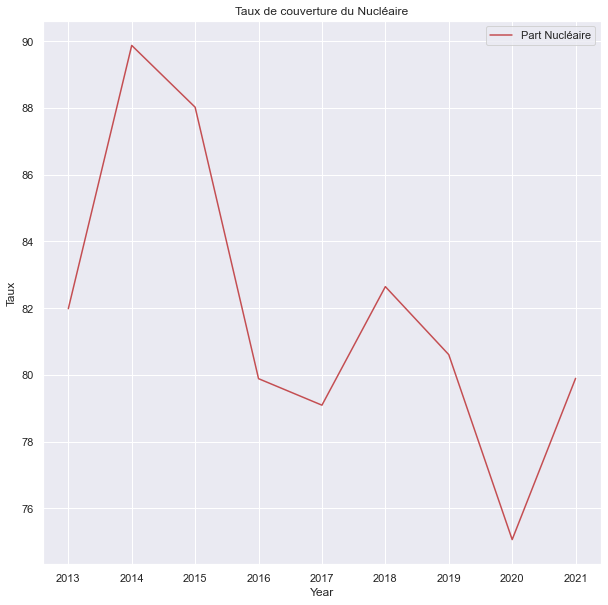

In [19]:
# Visualisation du taux de couverture de la production d'énergie nucléaire
plt.figure(figsize=(10,10))
sns.lineplot(x="Year", y="Part_Nucléaire (MW)", data=year_aggr, color = "r", label="Part Nucléaire")
plt.title("Taux de couverture du Nucléaire")
plt.ylabel("Taux")
plt.legend();


On constate une baisse de la part du nucléaire dans la consommation d'énergie au niveau national entre 2013 et 2021.

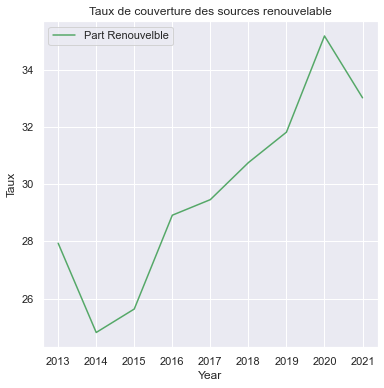

In [20]:
plt.figure(figsize=(6,6))
sns.lineplot(x="Year", y="Part_Renouvelable", data=year_aggr, color ="g", label="Part Renouvelble")
plt.title("Taux de couverture des sources renouvelable")
plt.ylabel("Taux")
plt.legend();

On constate une hausse de la part du renouvelable dans la consommation d'énergie au niveau national entre 2013 et 2021.

In [21]:
# On supprime les colonnes inutiles, on crée un nouveau dataframe "df" et on affiche les 5 premières lignes
df = year_aggr.iloc[:,:10]
df = df.drop(columns=["Code INSEE région","Pompage (MW)"])
df.head()

,Year,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Bioénergies (MW)
0,2013,984134263.0,87265040.0,806802087.0,31665608.0,9008891.0,149129252.0,12227527.0
1,2014,924697156.0,49924365.0,831008785.0,34116918.0,11639659.0,134720263.0,15020879.0
2,2015,946305720.0,66714884.0,832908808.0,42188171.0,14572733.0,117039522.0,15832717.0
3,2016,960630996.0,88787737.0,767408645.0,41835426.0,16521789.0,126717599.0,17423013.0
4,2017,958089446.0,105507116.0,757772631.0,48194982.0,17987913.0,106026436.0,18877342.0


Nous allons ensuite créer 5 nouveaux dataframe pour visualiser la part de chaque source d'énergie dans la production nationale de 2013, 2014, 2019, 2020 et 2021:


In [22]:
df_un = df[df.Year == 2013].transpose().reset_index()
df_un.rename(columns={"index": "Name", 0:"Quantité"}, inplace=True)
df_un.drop([0,1], inplace=True)
df_un


,Name,Quantité
2,Thermique (MW),87265040.0
3,Nucléaire (MW),806802087.0
4,Eolien (MW),31665608.0
5,Solaire (MW),9008891.0
6,Hydraulique (MW),149129252.0
7,Bioénergies (MW),12227527.0


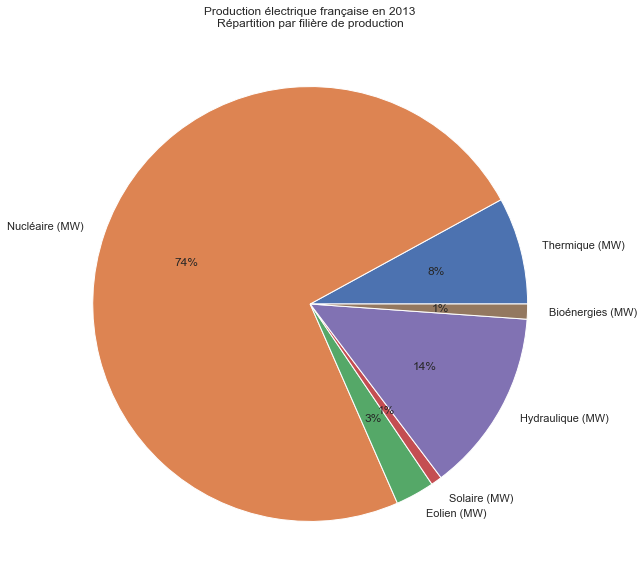

In [23]:
# Pie chart de la production énergetique 2013
plt.figure(figsize=(10,10))
label = [x for x in df_un.Name]
plt.pie(x= df_un.Quantité,labels=label,autopct='%.0f%%')
plt.title('Production électrique française en 2013\nRépartition par filière de production')
plt.show;

In [24]:
df_deux = df[df.Year == 2014].transpose().reset_index()
df_deux.rename(columns={"index": "Name", 1:"Quantité"}, inplace=True)
df_deux.drop([0,1], inplace=True)
df_deux

,Name,Quantité
2,Thermique (MW),49924365.0
3,Nucléaire (MW),831008785.0
4,Eolien (MW),34116918.0
5,Solaire (MW),11639659.0
6,Hydraulique (MW),134720263.0
7,Bioénergies (MW),15020879.0


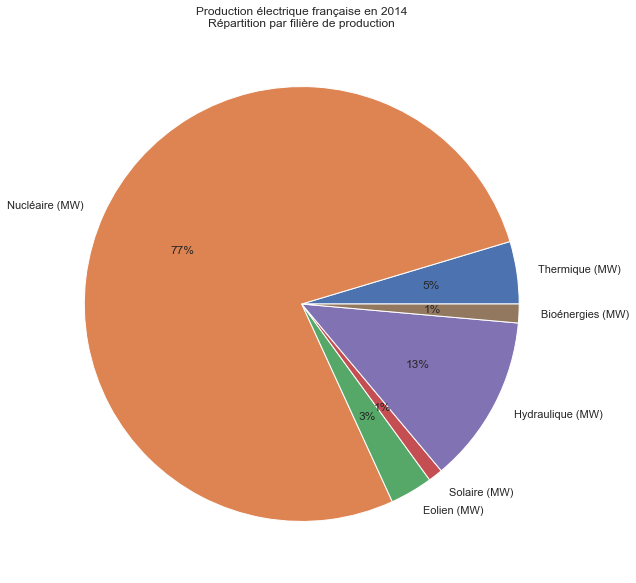

In [25]:
# Pie chart de la production énergetique 2014
plt.figure(figsize=(10,10))
label = [x for x in df_deux.Name]
plt.pie(x= df_deux.Quantité,labels=label,autopct='%.0f%%')
plt.title('Production électrique française en 2014\nRépartition par filière de production')
plt.show;

In [26]:
df_trois = df[df.Year == 2019].transpose().reset_index()
df_trois.rename(columns={"index": "Name", 6:"Quantité"}, inplace=True)
df_trois.drop([0,1], inplace=True)
df_trois

,Name,Quantité
2,Thermique (MW),82152897.0
3,Nucléaire (MW),758459526.0
4,Eolien (MW),67631922.0
5,Solaire (MW),24204370.0
6,Hydraulique (MW),119002296.0
7,Bioénergies (MW),19321315.0


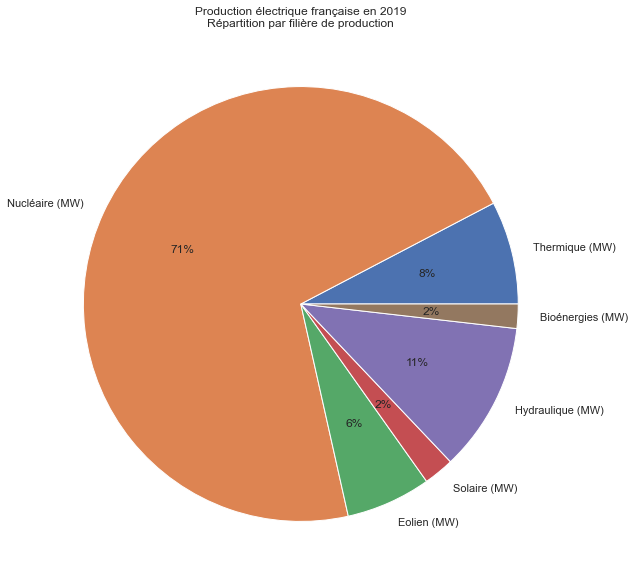

In [27]:
# Pie chart de la production énergetique de 2019
plt.figure(figsize=(10,10))
label = [x for x in df_trois.Name]
plt.pie(x= df_trois.Quantité,labels=label,autopct='%.0f%%')
plt.title('Production électrique française en 2019\nRépartition par filière de production')
plt.show;

In [28]:
df_cinq = df[df.Year == 2020].transpose().reset_index()
df_cinq.rename(columns={"index": "Name", 7:"Quantité"}, inplace=True)
df_cinq.drop([0,1], inplace=True)
df_cinq

,Name,Quantité
2,Thermique (MW),73543103.0
3,Nucléaire (MW),670460374.0
4,Eolien (MW),79400565.0
5,Solaire (MW),24925055.0
6,Hydraulique (MW),129611835.0
7,Bioénergies (MW),19357548.0


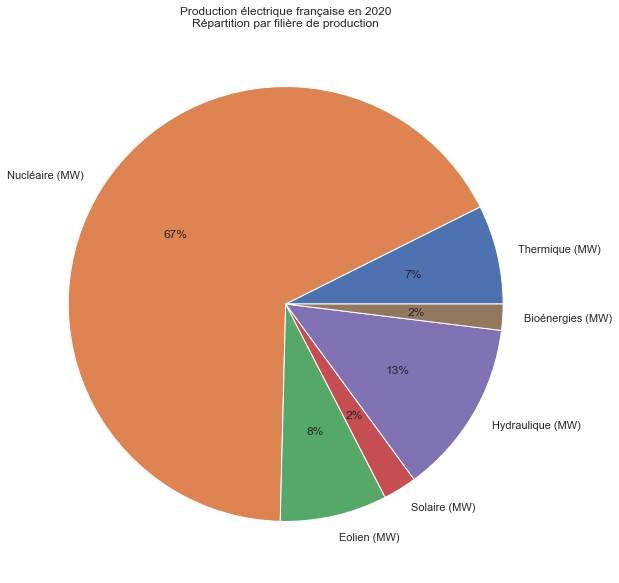

In [29]:
# Pie chart de la production énergetique de 2020
plt.figure(figsize=(10,10))
label = [x for x in df_cinq.Name]
plt.pie(x= df_cinq.Quantité,labels=label,autopct='%.0f%%')
plt.title('Production électrique française en 2020\nRépartition par filière de production')
plt.show;

In [30]:
df_quatre = df[df.Year == 2021].transpose().reset_index()
df_quatre.rename(columns={"index": "Name", 8:"Quantité"}, inplace=True)
df_quatre.drop([0,1], inplace=True)
df_quatre

,Name,Quantité
2,Thermique (MW),52634260.0
3,Nucléaire (MW),597336197.0
4,Eolien (MW),57927449.0
5,Solaire (MW),25624040.0
6,Hydraulique (MW),103882249.0
7,Bioénergies (MW),15950793.0


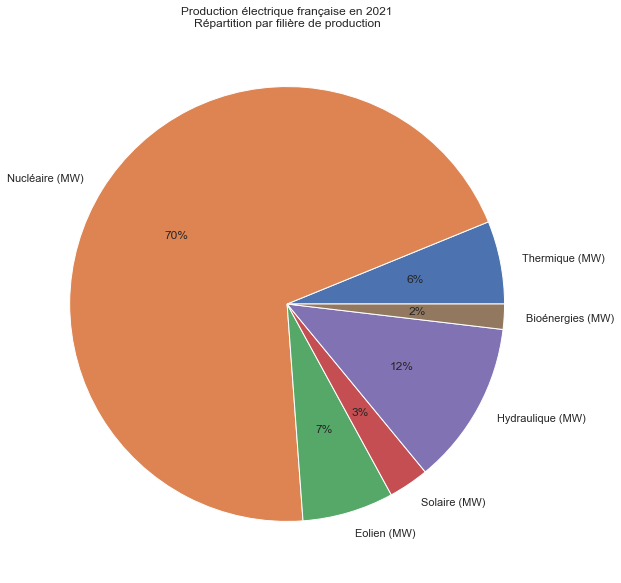

In [31]:
# Pie chart de 2021
plt.figure(figsize=(10,10))
label = [x for x in df_quatre.Name]
plt.pie(x= df_quatre.Quantité,labels=label,autopct='%.0f%%')
plt.title('Production électrique française en 2021\nRépartition par filière de production')
plt.show;

On constate une augmentation de l'éolien de 3% en 2013 à 8% en 2020 et 7% en 2021. Le solaire passe de 1 à 3%.
Globalement on a une augmentation légère du renouvelable et baisse légère du nucléaire.


In [32]:
# Creation d'un nouveau dataframe pour visualiser la consommation trimestrielle par année
eco_trimestre = eco.groupby(["Year","Trimestre"], as_index=False).sum()
eco_trimestre.drop(columns=["Code INSEE région","Month","Gmt"], inplace=True)

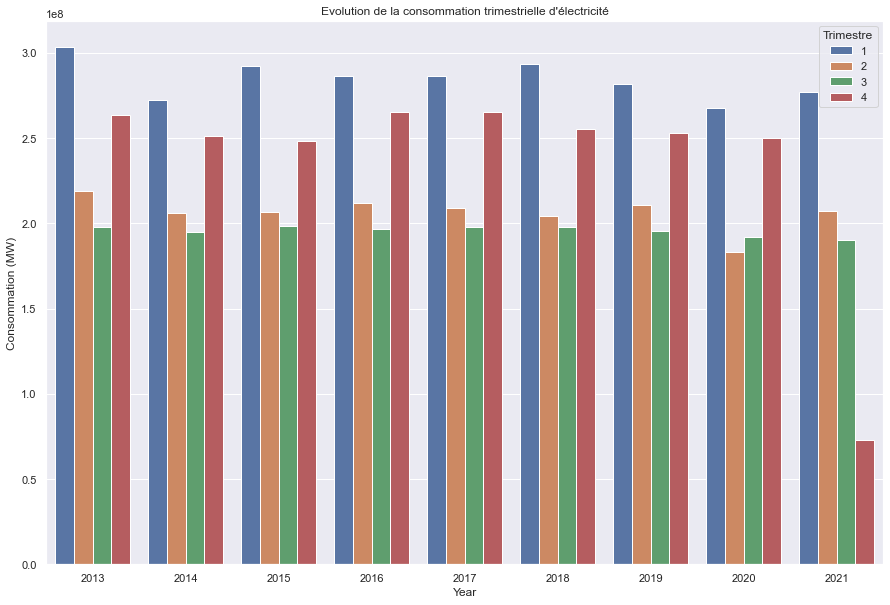

In [33]:
plt.figure(figsize=(15,10))
s3 = sns.barplot(x="Year", y="Consommation (MW)", hue="Trimestre", data=eco_trimestre)
s3.set_title("Evolution de la consommation trimestrielle d'électricité");

On constate que pour le premier et dernier trimestre on a une hausse de la consommation nationale à l'exception de Q4 2021 cela est dû à un manque de donnée pour cette période dans notre jeu de donnée base_energie.
Q1 et Q4 sont des périodes où il fait plus froid.

In [34]:
# Creation d'un nouveau dataframe pour visualiser la consommation mensuelle par année
eco_month = eco.groupby(["Year","Month"], as_index=False).sum()
eco_month.drop(columns=["Code INSEE région","Gmt"], inplace=True)

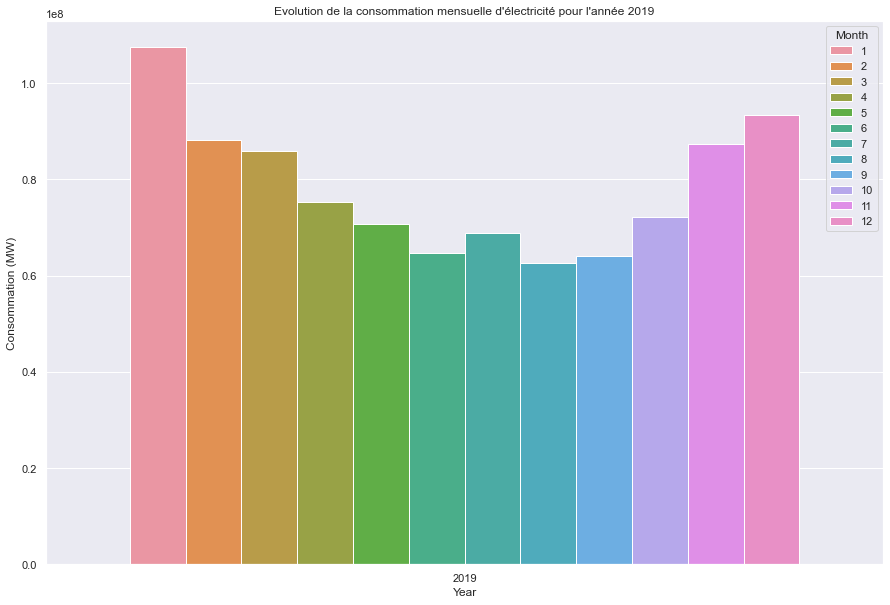

In [35]:
# Consommation mensuelle pour l'année 2019
plt.figure(figsize=(15,10))
s4 = sns.barplot(x="Year", y="Consommation (MW)", hue="Month", data=eco_month[eco_month.Year == 2019])
s4.set_title("Evolution de la consommation mensuelle d'électricité pour l'année 2019");

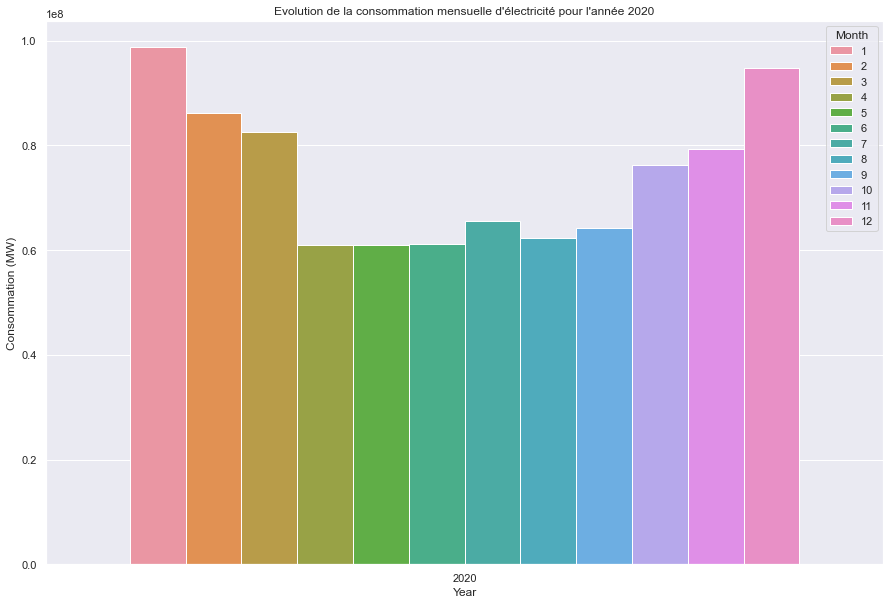

In [36]:
# Consommation mensuelle pour année 2020
plt.figure(figsize=(15,10))
s5 = sns.barplot(x="Year", y="Consommation (MW)", hue="Month", data=eco_month[eco_month.Year == 2020])
s5.set_title("Evolution de la consommation mensuelle d'électricité pour l'année 2020");

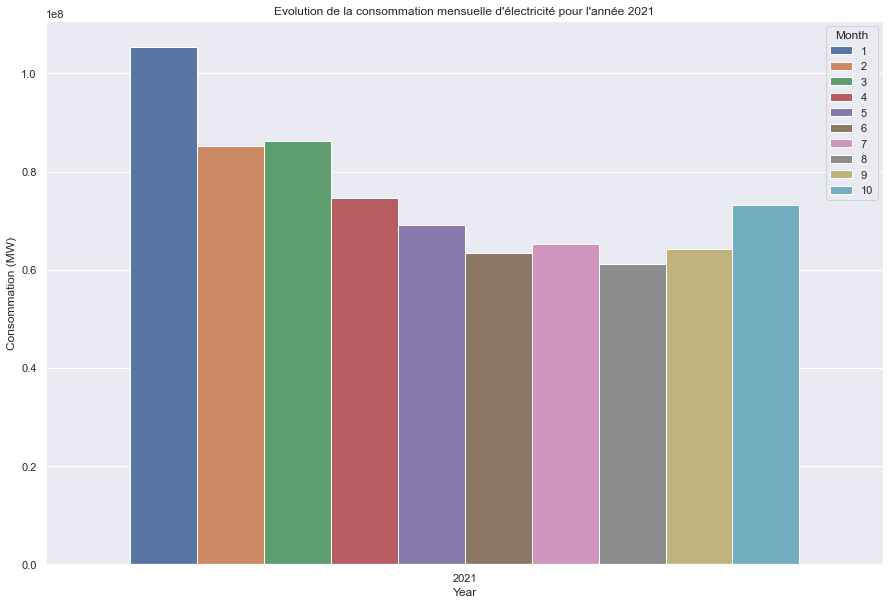

In [37]:
# Consommation mensuelle année 2021
plt.figure(figsize=(15,10))
s6 = sns.barplot(x="Year", y="Consommation (MW)", hue="Month", data=eco_month[eco_month.Year == 2021])
s6.set_title("Evolution de la consommation mensuelle d'électricité pour l'année 2021");

La visualisation de la consommation mensuelle pour les années 2019, 2020 et 2021 valide bien notre analyse sur la hausse de la consommation pour le premier et dernier trimestre de chaque année.
On constate que pour les periodes de janvier à mars et octobre à décembre la consommation est en hausse.

In [39]:
# Création d'un dataframe pour visualiser la consommation moyenne en fonction du jour de la semaine au niveau national
conso_hebdom = eco.groupby(['Weekday_number','Day_name'], as_index=False).agg({'Consommation (MW)':'mean'})
conso_hebdom

,Weekday_number,Day_name,Consommation (MW)
0,1,Lundi,4536.354019
1,2,Mardi,4652.886317
2,3,Mercredi,4663.957731
3,4,Jeudi,4656.963753
4,5,Vendredi,4604.404966
5,6,Samedi,4189.710107
6,7,Dimanche,3988.227156


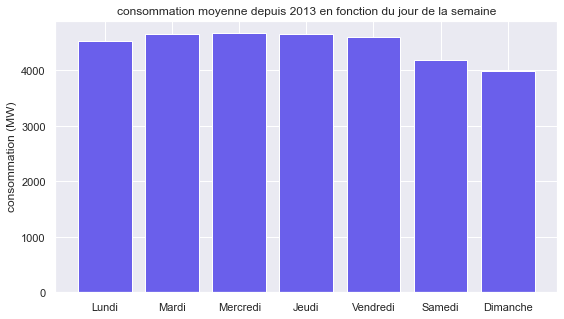

In [40]:
plt.figure(figsize=(9,5))
plt.bar(conso_hebdom.Day_name,conso_hebdom['Consommation (MW)'], color='#6a5feb')
plt.ylabel('consommation (MW)')
plt.title('consommation moyenne depuis 2013 en fonction du jour de la semaine');

On constate une concentration de la consommation en semaine et une baisse le weekend

In [41]:
#vérification statistique de l'impact du jour de la semaine sur la consommation
#on crée un nouveau et on renomme la colonne consommation (MW) dont le nom n'est pas adapté ensuite on fait le test
clonebase = eco
clonebase = clonebase.rename(columns={'Consommation (MW)':'conso'})
result = statsmodels.formula.api.ols('conso ~ Day_name', data = clonebase).fit()
table = statsmodels.api.stats.anova_lm(result)
table


,df,sum_sq,mean_sq,F,PR(>F)
Day_name,6.0,1.166094e+11,1.943490e+10,4219.520744,0.0
Residual,1858169.0,8.558631e+12,4.605949e+06,NaN,NaN


Le tableau ci-dessus montre que la P-value est de zéro, les modalités testées (jours de la semaine) ont bien un effet statistique significatif sur la variable cible.

In [42]:
# Création d'un dataframe pour visualiser la consommation par heure et par saison
saisons = {3:'printemps', 4:'printemps', 5:'printemps', 6:'été',7:'été',8:'été',
          9:'automne',10:'automne',11:'automne',12:'hiver',1:'hiver',2:'hiver'}
eco['saison'] = eco['Date - Heure'].apply(lambda x : saisons.get(int(x[5:7])))
dfg = eco.groupby(['Région','saison','Heure'], as_index = False).agg({'Consommation (MW)':'mean'})
dfg = dfg.groupby(['saison','Heure'], as_index = False).agg({'Consommation (MW)':'sum'})
dfgnat = dfg.groupby('Heure', as_index = False).agg({'Consommation (MW)':'mean'})

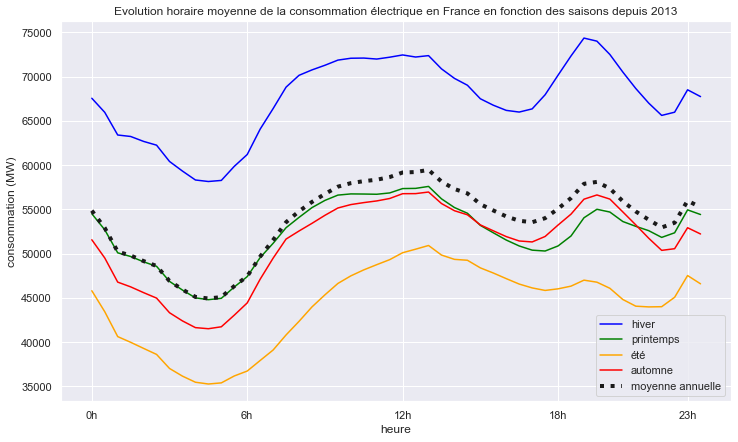

In [43]:
plt.figure(figsize=(12,7))
plt.plot(dfg['Heure'][dfg['saison'] =='hiver'], dfg['Consommation (MW)'][dfg['saison'] =='hiver'], color='blue', label='hiver');
plt.plot(dfg['Heure'][dfg['saison'] =='printemps'], dfg['Consommation (MW)'][dfg['saison'] =='printemps'], color='green', label='printemps')
plt.plot(dfg['Heure'][dfg['saison'] =='été'], dfg['Consommation (MW)'][dfg['saison'] =='été'], color='orange', label='été')
plt.plot(dfg['Heure'][dfg['saison'] =='automne'], dfg['Consommation (MW)'][dfg['saison'] =='automne'], color='red', label='automne')
plt.plot(dfgnat['Heure'], dfgnat['Consommation (MW)'], 'k:', linewidth=4, label='moyenne annuelle')
plt.xlabel('heure')
plt.ylabel('consommation (MW)')
plt.xticks(['00:00','06:00','12:00','18:00','23:00'],['0h','6h','12h','18h','23h'])
plt.title('Evolution horaire moyenne de la consommation électrique en France en fonction des saisons depuis 2013')
plt.legend();

On constate que quelque soit la saison on a une hausse de la consommation entre 6h et 13h environ mais également entre 18 et 20h environ.

In [44]:
# Vérification statistique de l'impact de l'heure sur la consommation
# Utilisation de la dataframe clonebase
result = statsmodels.formula.api.ols('conso ~ Heure', data = clonebase).fit()
table = statsmodels.api.stats.anova_lm(result)
table


,df,sum_sq,mean_sq,F,PR(>F)
Heure,47.0,2.274573e+11,4.839516e+09,1064.473407,0.0
Residual,1858128.0,8.447783e+12,4.546395e+06,NaN,NaN


Le tableau ci-dessus montre que la P-value est de zéro. Les modalités testées (heure de la journée) ont bien un effet statistique significatif sur la variable cible.

**Données au niveau régional**

In [45]:
# Annualisation des données pour chaque région
eco_year_aggr = eco.groupby(["Code INSEE région","Région","Year"], as_index=False).sum()
eco_year_aggr.drop(columns=["Month","Gmt"], inplace=True)

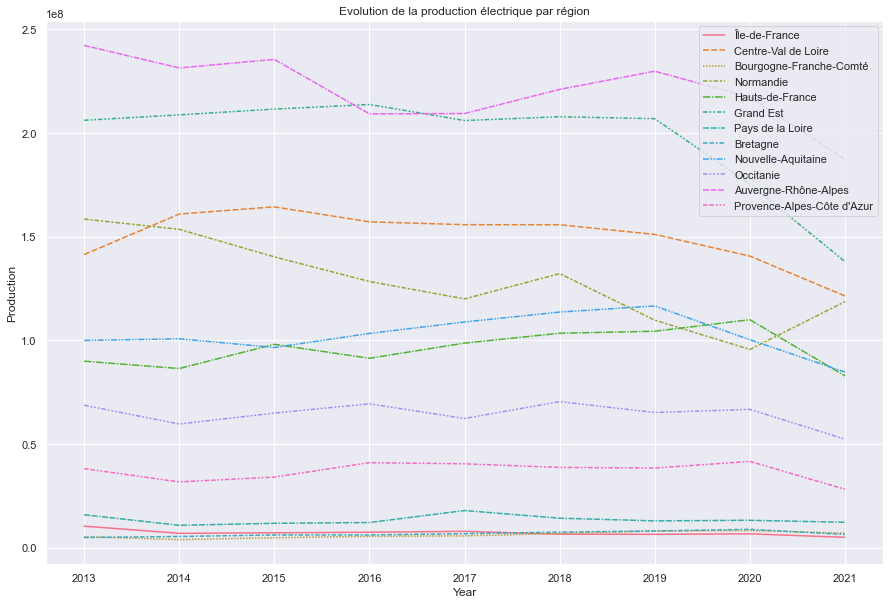

In [46]:
# Evolution de la production par région
plt.figure(figsize=(15,10))
s7 = sns.lineplot(data=eco_year_aggr, x="Year", y="Production", hue="Région" ,style="Région")
s7.set_title("Evolution de la production électrique par région")
plt.legend(loc='upper right');

On voit que les régions Auvergne-Rhône-Alpes, Grand Est et Centre-Val de Loire sont les régions qui produisent le plus d'énergie.
Bourgogne-Franche-Comté, Bretagne et Ile-de-France sont les régions qui produisent le moins d'énergie. 

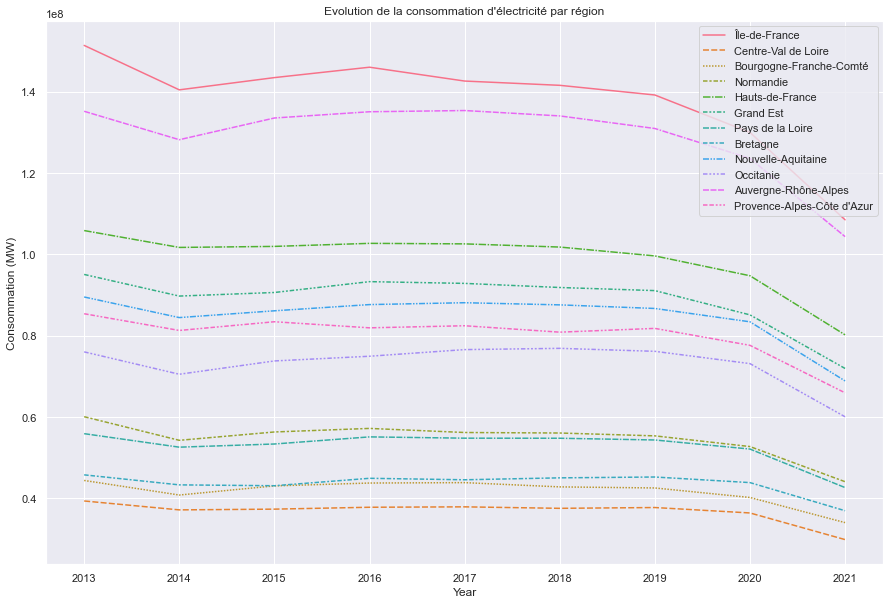

In [47]:
# Evolution de la consommation par région
plt.figure(figsize=(15,10))
s8 = sns.lineplot(data=eco_year_aggr, x="Year", y="Consommation (MW)", hue="Région" ,style="Région")
s8.set_title("Evolution de la consommation d'électricité par région");
plt.legend(loc='upper right');

On constate que Ile-de-France, qui ne produit que trés peu d'énergie, est celle qui consomme le plus.

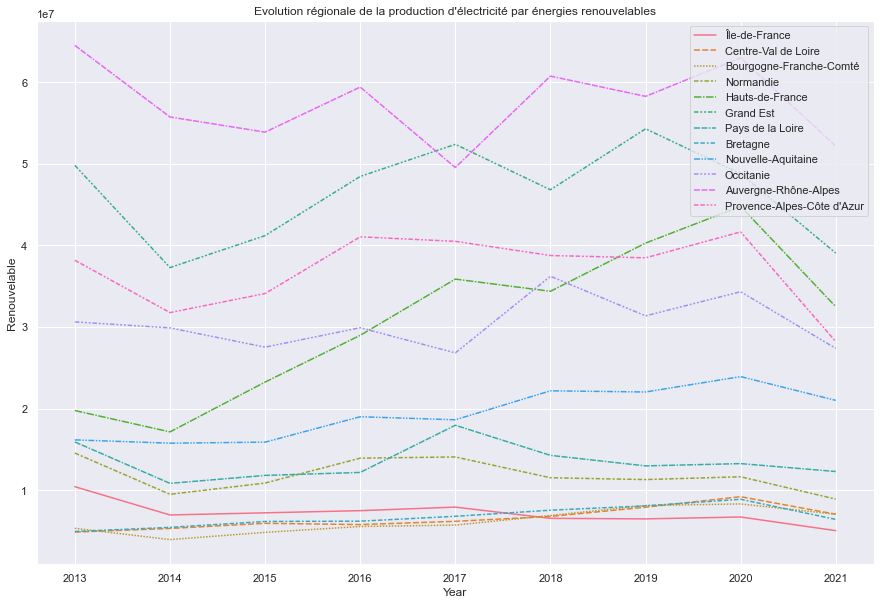

In [48]:
# Evolution du renouvelable par région
plt.figure(figsize=(15,10))
s9 = sns.lineplot(data=eco_year_aggr, x="Year", y="Renouvelable", hue="Région" ,style="Région")
s9.set_title("Evolution régionale de la production d'électricité par énergies renouvelables");
plt.legend(loc='upper right');


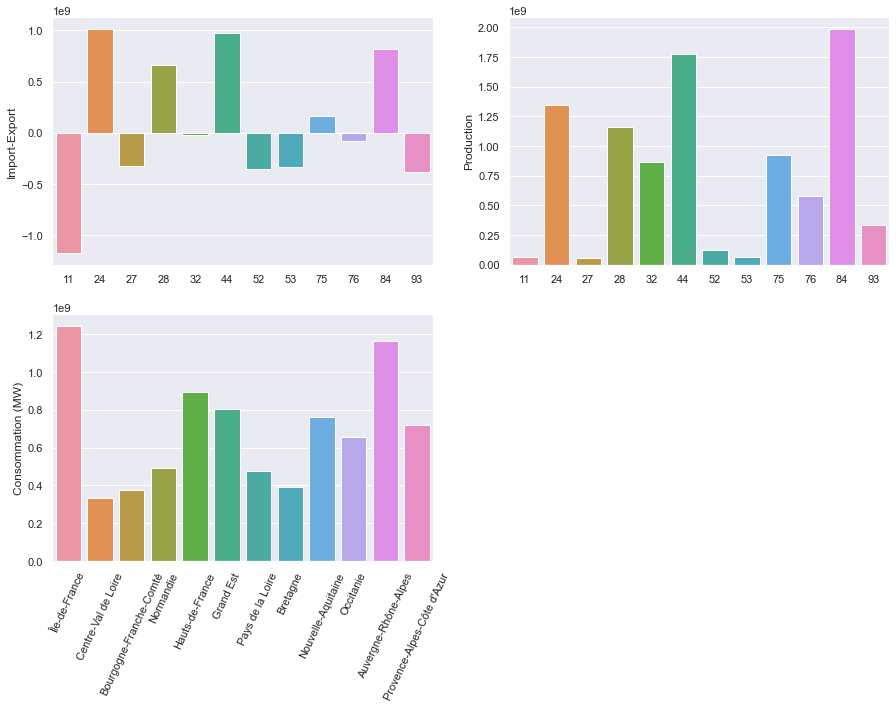

In [49]:
# Niveau de production, consommation et importation/exportation par région
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.barplot(x="Code INSEE région", y="Import-Export", data=eco_aggr)
plt.xlabel("")
plt.subplot(222)
sns.barplot(x="Code INSEE région", y="Production", data=eco_aggr)
plt.xlabel("")
plt.subplot(223)
sns.barplot(x="Région", y="Consommation (MW)", data=eco_aggr)
#plt.xticks(rotation = "vertical");
plt.xticks(rotation = 65)
plt.xlabel("");

On voit clairement les régions qui ont besoin de l'énergie produite par les autres régions: c'est le cas de l'Ile-de-France par exemple.

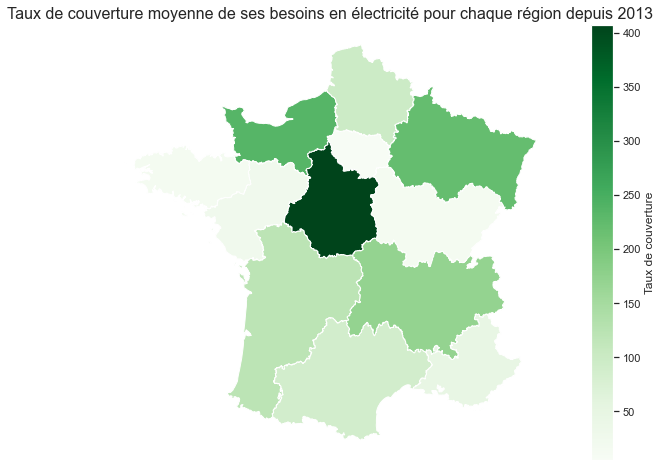

In [50]:
#carte de couverture des besoins par région

projet = eco.groupby('Région', as_index = False).agg({'Production' : 'mean' , 'Consommation (MW)' :'mean' })
projet['tx_couverture'] = projet['Production'] / projet['Consommation (MW)'] * 100

regions = gpd.read_file('regions-fr.json') 
df = pd.merge(regions, projet, how='left', left_on='nom', right_on='Région')

ax = df.plot(column ='tx_couverture', cmap ='Greens', figsize=(12,8), legend=True,
            legend_kwds={'label': "Taux de couverture",'orientation': "vertical"})
ax.set_axis_off()
ax.set_title('Taux de couverture moyenne de ses besoins en électricité pour chaque région depuis 2013', fontsize=16);

In [51]:
#taux de couverture des différentes sources d'énergie par région
dfg = eco[eco['Year'] >= 2020]
dfg = dfg.groupby('Région').agg('mean')

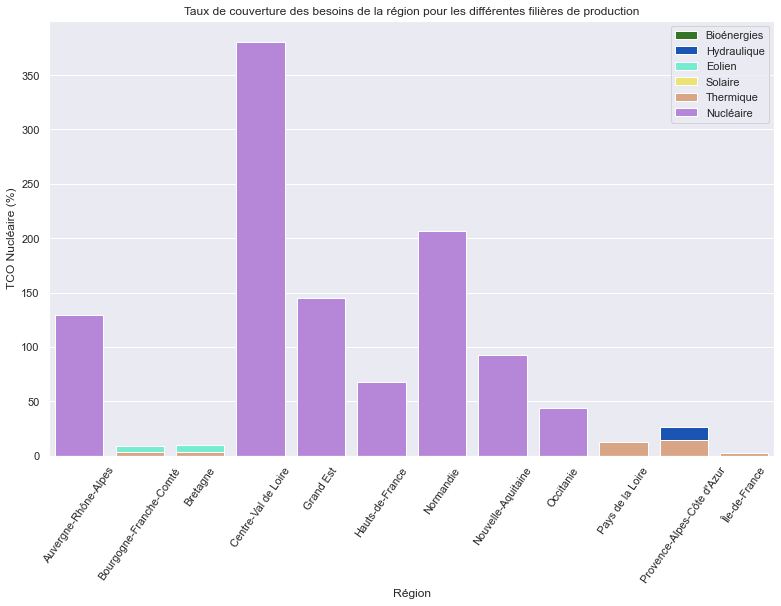

In [52]:
plt.figure(figsize=(13,8))
s1 = sns.barplot(x = dfg.index, y = dfg['TCO Bioénergies (%)'], color = '#2e811a', label='Bioénergies')
s2 = sns.barplot(x = dfg.index, y = dfg['TCO Hydraulique (%)'], color = '#004fce', label='Hydraulique')
s3= sns.barplot(x = dfg.index, y = dfg['TCO Eolien (%)'], color = '#63ffdb', label='Eolien')
s4= sns.barplot(x = dfg.index, y = dfg['TCO Solaire (%)'], color = '#fff363', label='Solaire')
s5 = sns.barplot(x = dfg.index, y = dfg['TCO Thermique (%)'], color = '#e6a278', label='Thermique')
s6 = sns.barplot(x = dfg.index, y = dfg['TCO Nucléaire (%)'], color = '#b878e6', label='Nucléaire')
plt.legend(loc='upper right')
plt.xticks(rotation=55)
plt.title('Taux de couverture des besoins de la région pour les différentes filières de production');

Ce graphique et la carte précédente illustrent que les régions qui ne possèdent pas de centrales nucléaires (Bourgogne-Franche-Comté ou Bretagne) ont un taux de couverture très faible.
A l'inverse, d'autres régions, comme la Normandie ou le Centre-Val de Loire, disposent d'un parc nucléaire significatif et fournissent de l'électricité à d'autres régions au delà de la couverture de leurs propres besoins.